# Importing libraries

- It is also imported the py. file that loads MNIST data set

In [1]:
from load_mnist import load_mnist

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Matplotlib settings

In [3]:
# setting size for plotting with matplotlib
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
    
plt.rc('axes', labelsize = 8)    # fontsize of the x and y labels 8
plt.rc('xtick', labelsize = 6)    # fontsize of the tick labels 6
plt.rc('ytick', labelsize = 6)    # fontsize of the tick labels 6
plt.rc('legend', fontsize= 6)     # legend fontsize 6
plt.rc('figure', titlesize = 10)  # fontsize of the figure title 10

## The variable "data" is a tuple containing the X and Y train and test inputs

In [4]:
data = load_mnist()

In [5]:
# assigning X, and Y
X_train = data[0]
Y_train = data[1]
X_test = data[2]
Y_test = data[3]

In [ ]:
When adding more layers it is important that the elements in the weight matrices are `initialized` randomly. Initializing each element by sampling from $ N(0, \sigma^2) $. The offset vectors initialized with zeros.

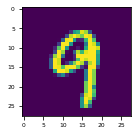

In [6]:
plt.figure(figsize=(2, 2))
plt.imshow(np.reshape(X_train[55555,:], [28,28]))

## Parameter initialization
When adding more layers it is important that the elements in the weight matrices are `initialized` randomly. Initializing each element by sampling from $ N(0, \sigma^2) $. The offset vectors initialized with zeros.


In [7]:
# X_train.shape[1] # 784 features 
# Y_train.shape[1] # M classes
def initialize_parameters(X_tr, Y_tr, layers):
    global costs, accuracies, theta, h_layer
    costs = []
    accuracies = []
    layers = layers
    theta = {}      # theta will contain parameters w and b for different layers. It is dictionary
    h_layer = len(layers)  # number of hidden layers
    layers.insert(0, X_tr.shape[1])
      
    for i in range(1, len(layers)):
        #theta["w" + str(i)] = np.random.randn(layers[i], layers[i-1]) / np.sqrt(layers[i-1])
        theta["w" + str(i)] = np.random.normal(0, 0.01, size = (layers[i], layers[i-1]))
        theta["b" + str(i)] = np.zeros((layers[i], 1))
    return costs, accuracies, theta, h_layer

## Sigmoid Activation

In [8]:
def sigmoid(z): 
    return 1/(1+np.exp(-z))  

def d_sigmoid(z):
    return (np.exp(-z)  / (1 + np.exp(-z))**2) 

## Rectified Linear Unit (ReLU) activation

In [24]:
def ReLu(z):
    return np.maximum(0,z)

def d_ReLu(z):
    return 1. * (z > 0)

## Softmax

In [9]:
def softmax(z):
    global out
    n = np.exp(z) # numerator (10,60000)
    d = np.sum(np.exp(z), axis=0) # denominator (60000,)
    out = (n / d).T
    return out

## Forward propagation

In [26]:
def forward(X_tr, h_layer, activation):
    global aux

    aux = {} 
    X_aux = X_tr.T

    for i in range(h_layer-1): # forward pass throught all layers with the sigmoid but the last layer
        z = theta["w" + str(i + 1)].dot(X_aux) + theta["b" + str(i + 1)]
        if activation == "Sigmoid":
            X_aux = sigmoid(z)
        elif activation == "Relu":
            X_aux = ReLu(z)
        aux["X_aux" + str(i + 1)] = X_aux
        aux["w" + str(i + 1)] = theta["w" + str(i + 1)]
        aux["z" + str(i + 1)] = z

    z = theta["w" + str(h_layer)].dot(X_aux) + theta["b" + str(h_layer)] #last layer pass with the softmax
    X_aux = softmax(z)
    aux["X_aux" + str(h_layer)] = X_aux
    aux["w" + str(h_layer)] = theta["w" + str(h_layer)]
    aux["z" + str(h_layer)] = z
    return aux

## Backward propagation

In [25]:
def backward(X_tr, Y_tr, aux, activation):
    global deriv
    deriv = {} # a dictionary to store all derivatives
    n = X_tr.shape[0]

    aux["X_aux0"] = X_tr.T

    X_aux = aux["X_aux" + str(h_layer)]
    dz = (X_aux - Y_tr).T

    dw = dz.dot(aux["X_aux" + str(h_layer - 1)].T) / n
    db = np.sum(dz, axis=1, keepdims=True) / n
    dX_auxPrev = aux["w" + str(h_layer)].T.dot(dz)

    deriv["dw" + str(h_layer)] = dw
    deriv["db" + str(h_layer)] = db

    for i in range(h_layer - 1, 0, -1):
        if activation == "Sigmoid":
            dz = dX_auxPrev * d_sigmoid(aux["z" + str(i)])
        
        elif activation == "Relu":
            dz = dX_auxPrev *d_ReLu(aux["z" + str(i)])

        dw = (1/n) * dz.dot(aux["X_aux" + str(i - 1)].T) 
        db = np.sum(dz, axis=1, keepdims=True) / n
        if i > 1:
            dX_auxPrev = aux["w" + str(i)].T.dot(dz)
        deriv["dw" + str(i)] = dw
        deriv["db" + str(i)] = db    
    return deriv

## Cost calculation

In [12]:
def cost_cal(out,Y_tr):
    global costs
    cost = (-1 / Y_tr.shape[0]) * np.sum((Y_tr * np.log(out)))
    costs.append(cost)
    return costs

## Update parameters w and b

In [13]:
def recalculate_theta(l_rate):
    global theta
    for i in range(1 , h_layer + 1):
        theta["w" + str(i)] = theta["w" + str(i)] - l_rate * deriv["dw" + str(i)]
        theta["b" + str(i)] = theta["b" + str(i)] - l_rate * deriv["db" + str(i)]
    return theta

## Accuracy calculation

In [14]:
def accuracy_cal(out, Y_tr):
    prediction = np.argmax(out, axis=1)
    y_t = np.argmax(Y_tr,axis=1) # y_test is y_t
    accuracy = (prediction==y_t).mean()*100
    accuracies.append(accuracy)
    return accuracies

## Mini-batch

In [15]:
def mini_batch(batch):
    global X_tr, Y_tr
    sample = np.random.randint(0, X_train.shape[0], size=(batch))

    X_tr = X_train[sample]
    Y_tr = Y_train[sample]
    return X_tr, Y_tr

## Decreasing learning rate $lr = lr_0.e^{-k.i}$

In [54]:
def exp_decay(j, l_r):
    global l_rate
    k=0.005
    l_rate = l_r * np.exp(-k*j)
    return l_rate

## Main function

In [55]:
def regression_logi(x, y, learning_rate, epoch, batch, layers, activation_function):
    X_train = x
    Y_train = y
    l_r = learning_rate # to avoid the decayin learning rate change lrate for l_r
    epoch = epoch   # mumber of passes of the sample for the training dataset
    batch = batch   # ramdom sample for x and y
    epochs = []
    layers = layers
    activation = activation_function
    mini_batch(batch) # create a sample for training data
    initialize_parameters(X_tr, Y_tr, layers)    # initialize parameters based on the sample data and not for the whole training data

    for j in range(epoch):
        mini_batch(batch)
        forward(X_tr, h_layer, activation)
        accuracy_cal(out, Y_tr)
        cost_cal(out, Y_tr)
        backward(X_tr, Y_tr, aux, activation)
        exp_decay(j, l_r)
        recalculate_theta(l_rate)
    return costs, accuracies

## Results when using: sigmoid and relu activation functions

In [117]:
sigmoid_data = regression_logi(X_train, Y_train, learning_rate= 0.6, epoch=840, batch=500, layers=[200,10], activation_function="Sigmoid")

In [118]:
relu_data = regression_logi(X_train, Y_train, learning_rate= 0.6, epoch=840, batch=500, layers=[200,10], activation_function= "Relu")

## Plots

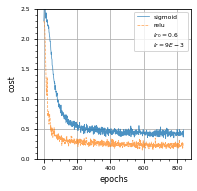

In [138]:
fig1 = plt.figure(figsize=cm2inch((7,7))) #7,7 for the report
ax = fig1.add_subplot()
ax.plot(sigmoid_data[0], linestyle='solid', linewidth=0.75, label="sigmoid", alpha=0.8)
ax.plot(relu_data[0], linestyle='dashed', linewidth=0.75, label="relu", alpha=0.7)
ax.plot([], [], ' ', label="$lr_0=0.6$\n$lr=9E-3$")
ax.set_xlabel("epochs")
ax.set_ylabel("cost")
ax.grid(b=bool)
ax.minorticks_on()
ax.legend(loc="upper right")
ax.set_ylim(0, 2.5)
#plt.savefig('cost3.jpg',bbox_inches='tight', dpi=300)
plt.show()

In [116]:
np.mean(train_data[1][-10:])

88.44000000000001

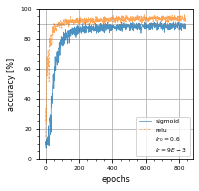

In [139]:
fig1 = plt.figure(figsize=cm2inch((7,7))) #7,7 for the report
ax = fig1.add_subplot()
ax.plot(sigmoid_data[1], linestyle='solid', linewidth=0.75, label="sigmoid", alpha=0.8)
ax.plot(relu_data[1], linestyle='dashed', linewidth=0.75, label="relu", alpha=0.7)
ax.plot([], [], ' ', label="$lr_0=0.6$\n$lr=9E-3$")
ynew = 90
ax.axhline(ynew, color='gray', linewidth=0.5)
ax.set_xlabel("epochs")
ax.set_ylabel("accuracy [%]")
ax.grid(b=bool)
ax.minorticks_on()
ax.legend(loc="lower right")
ax.set_ylim(0, 100)
#plt.savefig('acc3.jpg',bbox_inches='tight', dpi=300)
plt.show()